In [1]:
import numpy as np
import argparse
import os
import sys
import torch
import torch.fft as F
from importlib import reload
from torch.nn.functional import relu
import torch.nn as nn
import torch.nn.functional as Func
import torch.optim as optim
import utils
from utils import *

from matplotlib import pyplot as plt
import random
import copy
from sklearn.model_selection import train_test_split

import skimage
from mnet import MNet
from loupe_env.loupe_wrap import *
from mask_backward_v1 import mask_backward, mask_eval
from sigpy.mri.app import TotalVariationRecon

sys.path.insert(0,'/home/huangz78/mri/unet/')
from unet_model import UNet

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [6]:
torch.cuda.is_available()
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu" 
device = torch.device(dev)  
a = torch.zeros(4,3)    
a = a.to(device)

# Evaluation

In [6]:
testdata = torch.tensor(np.load('/mnt/shared_a/data/fastMRI/knee_singlecoil_test.npz')['data'])
print('test data shape: ',testdata.shape)

test data shape:  torch.Size([1300, 320, 320])


In [5]:
# load mnet
sparsity = .25
preselect_num = 16
unet_skip = True
mnet = MNet(beta=1,in_channels=2,out_size=320-preselect_num, imgsize=(320,320),poolk=3)
# mnetpath = '/home/huangz78/checkpoints/mnet_split_trained_cf10_bg_43.pt'
# mnetpath = '/home/huangz78/checkpoints/mnet_split_trained_cf16_bg_64.pt'
# mnetpath = '/home/huangz78/checkpoints/mnet_split_trained_cf8_bg_32.pt'
mnetpath = '/home/huangz78/checkpoints/checkpointsmnet_split_trained_cf16_bg_64.pt'
checkpoint = torch.load(mnetpath)
mnet.load_state_dict(checkpoint['model_state_dict'])
# mnet.apply(mnet_weights_init)
mnet.eval()
print('MNet loaded successfully from: ' + mnetpath)

unet_recon = UNet(n_channels=1,n_classes=1,bilinear=(not unet_skip),skip=unet_skip)
# unetpath = '/home/huangz78/checkpoints/unet_split_trained_cf8_bg_32.pt'
unetpath = '/home/huangz78/checkpoints/checkpointsunet_split_trained_cf16_bg_64.pt'
# unetpath = '/home/huangz78/checkpoints/unet_split_trained_cf16_bg_64.pt'
# unetpath = '/home/huangz78/checkpoints/unet_split_trained_cf10_bg_43.pt'
checkpoint = torch.load(unetpath)
unet_recon.load_state_dict(checkpoint['model_state_dict'])
print('Unet loaded successfully from: ' + unetpath )
unet_recon.eval()
print('nn\'s are ready')

MNet loaded successfully from: /home/huangz78/checkpoints/checkpointsmnet_split_trained_cf16_bg_64.pt
Unet loaded successfully from: /home/huangz78/checkpoints/checkpointsunet_split_trained_cf16_bg_64.pt
nn's are ready


In [ ]:
# load data and eval
def mnet_eval(testdata,mnet,unet):
    for ind in range(testdata.shape[0]):
        testdata[ind,:,:] = testdata[ind,:,:]/torch.max(testdata[ind,:,:])
    print('test data size:', testdata.shape)
    

# print eval result

test data size: torch.Size([1300, 320, 320])


# comparison between MNet and Loupe

In [2]:
dtyp = torch.float
testxdata  = np.load('/home/huangz78/data/testdata_x.npz')
testydata  = np.load('/home/huangz78/data/testdata_y.npz')
testxfull = torch.tensor(testxdata['xfull'],dtype=dtyp)
testyfull = torch.tensor(testydata['yfull'],dtype=torch.cfloat)

In [3]:
# sparsity = .25
# preselect_num = 24
# unet_skip = True

sparsity = .125
preselect_num = 8
unet_skip = True

In [4]:
# load mnet
mnet = MNet(beta=1,in_channels=2,out_size=320-preselect_num, imgsize=(320,320),poolk=3)
# mnetpath = '/home/huangz78/checkpoints/mnet.pth'
mnetpath = '/home/huangz78/checkpoints/mnet_split_trained_cf8_bg_32.pt'
checkpoint = torch.load(mnetpath)
mnet.load_state_dict(checkpoint['model_state_dict'])
mnet.eval()
print('MNet loaded successfully from: ' + mnetpath)

unet_recon = UNet(n_channels=1,n_classes=1,bilinear=(not unet_skip),skip=unet_skip)
unetpath = '/home/huangz78/checkpoints/unet_1_True.pth'
checkpoint = torch.load(unetpath)
unet_recon.load_state_dict(checkpoint['model_state_dict'])
print('Unet loaded successfully from: ' + unetpath )
unet_recon.eval()
print('nn\'s are ready')

MNet loaded successfully from: /home/huangz78/checkpoints/mnet_split_trained_cf8_bg_32.pt
Unet loaded successfully from: /home/huangz78/checkpoints/unet_1_True.pth
nn's are ready


In [ ]:
def mnet_eval(mnet,unet,testdata,preselect_num,sparsity,\
             batchsize=5,mode='unet',\
             Lambda=1e-4,\
             normalize=False):
    
    # prepare test data for mnet input
    nimgs = testdata.shape[0]; heg = testdata.shape[1]; wid = testdata.shape[2]
    
    data = torch.zeros(nimgs,2,heg,wid)    
    lf_mask = mask_naiveRand(heg,fix=preselect_num,other=0,roll=False)
    data[:,0,lf_mask==1,:] = torch.real(testdata[:,lf_mask==1,:])
    data[:,1,lf_mask==1,:] = torch.imag(testdata[:,lf_mask==1,:])
    
    pred_mnet = torch.zeros((nimgs,heg))
    batchnums = int(np.ceil(nimgs/batchsize))
    batchind = 0
    while batchind < batchnums:
        batch = np.arange(batchsize*batchind, min(batchsize*(batchind+1),nimgs))
        databatch = data[batch]
        preds = mnet_wrapper(mnet,databatch,budget=int(heg*sparsity)-preselect_num,\
                             imgshape=[heg,wid],normalize=True,detach=True)
        pred_mnet[batch] = F.ifftshift(preds,dim=1)
        batchind += 1
    
    observed_kspace = torch.zeros_like(testdata)
    for ind in range(len(data)):
        observed_kspace[ind,pred_mnet[ind,:]==1,:] = testdata[ind,pred_mnet[ind,:]==1,:]
    imgs_recon = torch.zeros(testdata.shape)
    
    if mode == 'unet':
        input_unet = F.ifftn(observed_kspace,dim=(1,2),norm='ortho').abs().view(nimgs,1,heg,wid)
        batchind = 0
        while batchind < batchnums:
            batch = np.arange(batchsize*batchind, min(batchsize*(batchind+1),nimgs))
            databatch = input_unet[batch]
            if not normalize:
                imgs_recon[batch] = torch.squeeze(unet(databatch).detach())
            else:
                recon_batch = unet(databatch).detach()
                for ind in range(len(recon_batch)):
                    recon_batch[ind] = recon_batch[ind]/torch.max(torch.abs(torch.flatten(recon_batch[ind])))
                imgs_recon[batch] = torch.squeeze(recon_batch)
            batchind += 1
    elif mode == 'sigpy':
        mps = np.ones((1,heg,wid))
        for ind in range(len(observed_kspace)):
            y_tmp = observed_kspace[ind,:,:].view(-1,heg,wid).numpy()
            imgs_recon[ind,:,:] = torch.tensor(\
                       np.fft.ifftshift(np.abs(TotalVariationRecon(y_tmp, mps, Lambda,show_pbar=False).run())) )

    ssim = compute_ssim(imgs_recon,testdata)
    psnr = compute_psnr(imgs_recon,testdata)
    hfen = np.zeros((nimgs))
    for ind in range(nimgs):
        hfen[ind] = compute_hfen(imgs_recon[ind,:,:].to(torch.cfloat),testdata[ind,:,:].to(torch.cfloat))
    rmse = np.zeros((nimgs))
    for ind in range(nimgs):
        rmse[ind] = torch.norm(imgs_recon[ind,:,:] - testdata[ind,:,:],2)/torch.norm(testdata[ind,:,:],2)
    
    return ssim,psnr,hfen,rmse

In [ ]:
mnet_test_mode = 'sigpy'
ssim_mnet,psnr_mnet,hfen_mnet,rmse_mnet = mnet_eval(mnet,unet_recon,testyfull,preselect_num=24,sparsity=.25,\
                               batchsize=5,mode=mnet_test_mode,normalize=False)

In [ ]:
print('mnet test mode: ',mnet_test_mode)
print('ssim mnet: ',np.mean(ssim_mnet))
print('psnr mnet: ',np.mean(psnr_mnet))
print('hfen mnet: ',np.mean(hfen_mnet))
print('rmse mnet: ',np.mean(rmse_mnet))

In [ ]:
# load unet
unet_skip = False
UNET = UNet(n_channels=1,n_classes=1,bilinear=(not unet_skip),skip=unet_skip)
# load loupe model
loupepath = '/home/huangz78/checkpoints/loupe_skipTrue.pt'
loupe = LOUPE(n_channels=1,unet_skip=True,shape=[320,320],slope=5,sparsity=sparsity,\
                  preselect=True,preselect_num=preselect_num,\
                  sampler=None,unet=UNET)

In [ ]:
def loupe_eval(loupe,testdata,preselect_num,sparsity,\
               batchsize=5,mode='unet',\
               Lambda=1e-4):
    loupe.eval()
    if preselect_num > 0:
        assert loupe.preselect
        assert loupe.preselect_num == preselect_num
    # prepare test data for mnet input
    nimgs = testdata.shape[0]; heg = testdata.shape[1]; wid = testdata.shape[2]    
    data = torch.reshape(testdata,(nimgs,1,heg,wid))
    
    pred_loupe = torch.zeros((nimgs,heg,wid)) 
    batchnums = int(np.ceil(nimgs/batchsize))
    batchind = 0    
    if mode == 'unet':           
        while batchind < batchnums:
            batch = np.arange(batchsize*batchind, min(batchsize*(batchind+1),nimgs))
            databatch = data[batch]
            preds,_ = loupe(databatch)
            pred_loupe[batch] = torch.squeeze( preds.detach() )
            batchind += 1
    elif mode == 'sigpy':
        masks_loupe = torch.zeros((batchnums,heg))
        while batchind < batchnums:
            batch = np.arange(batchsize*batchind, min(batchsize*(batchind+1),nimgs))
            databatch = data[batch]
            _,mask = loupe.samplers[0](databatch,sparsity)

            mask = torch.squeeze(mask.detach())
            masks_loupe[batchind,:] = mask
            observed_kspace = torch.zeros_like(databatch)
            imgs_recon = torch.zeros((len(databatch),heg,wid))
            observed_kspace[:,:,mask==1,:] = databatch[:,:,mask==1,:]
            
            mps = np.ones((1,heg,wid))
            for ind in range(len(observed_kspace)):
                y_tmp = observed_kspace[ind,0,:,:].view(-1,heg,wid).numpy()
                imgs_recon[ind,:,:] = torch.tensor(\
                           np.fft.ifftshift(np.abs(TotalVariationRecon(y_tmp, mps, Lambda,show_pbar=False).run())) )
            pred_loupe[batch] = imgs_recon
            batchind += 1
        
    ssim = compute_ssim(pred_loupe,testdata)
    psnr = compute_psnr(pred_loupe,testdata)
    hfen = np.zeros((nimgs))
    for ind in range(nimgs):
        hfen[ind] = compute_hfen(pred_loupe[ind,:,:].to(torch.cfloat),testdata[ind,:,:].to(torch.cfloat))
    rmse = np.zeros((nimgs))
    for ind in range(nimgs):
        rmse[ind] = torch.norm(pred_loupe[ind,:,:] - testdata[ind,:,:],2)/torch.norm(testdata[ind,:,:],2)
    
    return ssim,psnr,hfen,rmse

In [ ]:
loupe_test_mode = 'unet'
ssim_loupe,psnr_loupe,hfen_loupe,rmse_loupe = loupe_eval(loupe,testyfull,preselect_num=24,sparsity=.25,\
                               batchsize=5,mode=loupe_test_mode)

In [ ]:
print('mnet test mode: ',mnet_test_mode)
print('ssim loupe: ',np.mean(ssim_loupe))
print('psnr loupe: ',np.mean(psnr_loupe))
print('hfen loupe: ',np.mean(hfen_loupe))
print('rmse loupe: ',np.mean(rmse_loupe))

# main demo: show masks and triviality check

In [9]:
heg = 320
wid = 320
sparsity = 53/320 # .25 # .125
preselect_num = 10 # 16 # 8
budget = int(heg * sparsity - preselect_num)
unet_skip = True
print(f'budget is {budget}')

budget is 43


In [10]:
# load mnet
mnet = MNet(beta=1,in_channels=2,out_size=320-preselect_num, imgsize=(320,320),poolk=3)
mnetpath = '/home/huangz78/checkpoints/mnet_split_trained_cf10_bg_43.pt'
# mnetpath = '/home/huangz78/checkpoints/mnet_split_trained_cf16_bg_64.pt'
# mnetpath = '/home/huangz78/checkpoints/mnet_split_trained_cf8_bg_32.pt'
checkpoint = torch.load(mnetpath)
mnet.load_state_dict(checkpoint['model_state_dict'])
# mnet.apply(mnet_weights_init)
mnet.eval()
print('MNet loaded successfully from: ' + mnetpath)

unet_recon = UNet(n_channels=1,n_classes=1,bilinear=(not unet_skip),skip=unet_skip)
# unetpath = '/home/huangz78/checkpoints/unet_split_trained_cf8_bg_32.pt'
# unetpath = '/home/huangz78/checkpoints/unet_split_trained_cf16_bg_64.pt'
unetpath = '/home/huangz78/checkpoints/unet_split_trained_cf10_bg_43.pt'
checkpoint = torch.load(unetpath)
unet_recon.load_state_dict(checkpoint['model_state_dict'])
print('Unet loaded successfully from: ' + unetpath )
unet_recon.eval()
print('nn\'s are ready')

MNet loaded successfully from: /home/huangz78/checkpoints/mnet_split_trained_cf10_bg_43.pt
Unet loaded successfully from: /home/huangz78/checkpoints/unet_split_trained_cf10_bg_43.pt
nn's are ready


In [ ]:
imgind = 126
kimg = testyfull[imgind].view(1,1,heg,heg)

_,loupe_mask = loupe.samplers[0](kimg,sparsity)
loupe_mask = torch.squeeze(loupe_mask.detach())
kplot(loupe_mask,roll=True)

In [11]:
# load data
imgs = torch.tensor( np.load('/home/huangz78/data/data_gt.npz')['imgdata'] ).permute(2,0,1)
labels = torch.tensor( np.load('/home/huangz78/data/data_gt_greedymask.npz')['mask'].T ) # labels are already rolled

/opt/anaconda/envs/pyenv/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


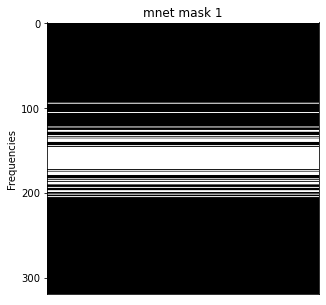

quality of mnet mask for image 1:  0.0989498757954216


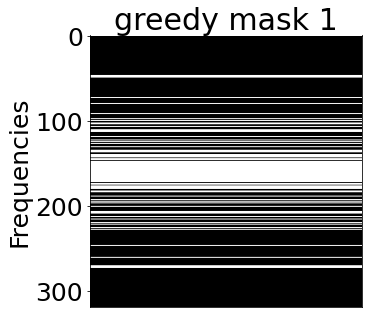

quality of greedy mask for image 1:  0.11946519274018726


In [12]:
imgind_1 = 12
img_1 = imgs[imgind_1,:,:].view(1,1,heg,wid)/torch.max(torch.abs(imgs[imgind_1,:,:]))
kimg_1 = F.fftshift(F.fftn(img_1,dim=(2,3),norm='ortho').to(torch.cfloat)) # kspace shifted
lfmask,_,_ = mask_naiveRand(heg,fix=preselect_num,other=0,roll=True)
rdmask,_,_ = mask_naiveRand(heg,fix=preselect_num,other=budget,roll=True)

kimg_lf_1 = torch.zeros(1,2,heg,wid)    
kimg_lf_1[:,0,lfmask==1,:] = torch.real(kimg_1[:,:,lfmask==1,:])
kimg_lf_1[:,1,lfmask==1,:] = torch.imag(kimg_1[:,:,lfmask==1,:])
# _,loupe_mask = loupe.samplers[0](kimg,sparsity)
# loupe_mask = torch.squeeze(loupe_mask.detach())
# kplot(loupe_mask,roll=True)

mnet_mask_1 = mnet_wrapper(mnet,kimg_lf_1,budget=int(heg*sparsity)-preselect_num,\
                             imgshape=[heg,wid],normalize=True,detach=True)
mnet_mask_1 = torch.squeeze(mnet_mask_1)

greedy_mask_1 = labels[imgind_1,:]

kplot(mnet_mask_1,roll=False,img_name='mnet mask 1')
print('quality of mnet mask for image 1: ', mask_eval(mnet_mask_1.view(-1,320),img_1.view(1,heg,wid),\
              mode='UNET',UNET=unet_recon,dtyp=torch.float,\
              Lambda=10**(-4.3),hfen=False))

kplot(greedy_mask_1,roll=False,img_name='greedy mask 1')
print('quality of greedy mask for image 1: ',mask_eval(greedy_mask_1.view(-1,320),img_1.view(1,heg,wid),\
              mode='UNET',UNET=unet_recon,dtyp=torch.float,\
              Lambda=10**(-4.3),hfen=False))

0


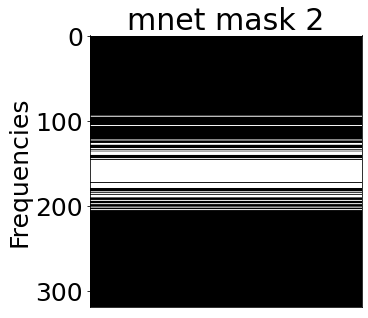

direct input difference:  tensor([[[[ 0.0013,  0.0196, -0.0033,  ...,  0.0018,  0.0044,  0.0364],
          [ 0.0229, -0.0068, -0.0053,  ...,  0.0056,  0.0148,  0.0393],
          [ 0.0061,  0.0098,  0.0127,  ...,  0.0087, -0.0129,  0.0377],
          ...,
          [ 0.0146, -0.0057,  0.0049,  ..., -0.0029,  0.0099,  0.0319],
          [ 0.0061,  0.0377, -0.0129,  ..., -0.0014,  0.0127,  0.0098],
          [ 0.0229,  0.0393,  0.0148,  ...,  0.0155, -0.0053, -0.0068]],

         [[ 0.0276, -0.0129, -0.0064,  ..., -0.0048,  0.0241,  0.0044],
          [-0.0061,  0.0135, -0.0018,  ..., -0.0033,  0.0024, -0.0036],
          [-0.0079, -0.0151, -0.0013,  ...,  0.0167, -0.0038, -0.0307],
          ...,
          [-0.0150,  0.0156, -0.0084,  ...,  0.0073,  0.0076,  0.0218],
          [ 0.0079,  0.0307,  0.0038,  ...,  0.0073,  0.0013,  0.0151],
          [ 0.0061,  0.0036, -0.0024,  ...,  0.0082,  0.0018, -0.0135]]]])
sigmoid mnet output difference:  tensor([[ 2.5460e-11,  9.3588e-11,  2.4144

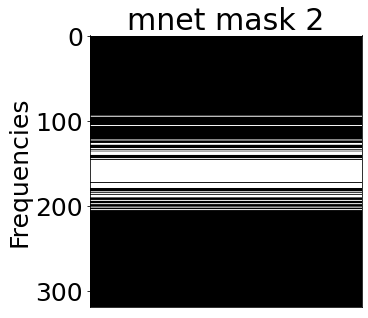

direct input difference:  tensor([[[[-0.0278,  0.0130, -0.0128,  ...,  0.0085,  0.0323,  0.0086],
          [ 0.0238, -0.0198, -0.0326,  ...,  0.0202, -0.0042,  0.0008],
          [-0.0026,  0.0062,  0.0197,  ..., -0.0131, -0.0215,  0.0074],
          ...,
          [-0.0157, -0.0367, -0.0023,  ..., -0.0232, -0.0208, -0.0166],
          [-0.0026,  0.0074, -0.0215,  ..., -0.0297,  0.0197,  0.0062],
          [ 0.0238,  0.0008, -0.0042,  ...,  0.0018, -0.0326, -0.0198]],

         [[-0.0037, -0.0172,  0.0259,  ..., -0.0196,  0.0111,  0.0221],
          [-0.0047,  0.0228,  0.0256,  ..., -0.0083,  0.0204,  0.0108],
          [ 0.0033,  0.0058,  0.0007,  ...,  0.0362,  0.0231, -0.0053],
          ...,
          [-0.0484, -0.0269, -0.0441,  ..., -0.0285, -0.0317,  0.0019],
          [-0.0033,  0.0053, -0.0231,  ..., -0.0173, -0.0007, -0.0058],
          [ 0.0047, -0.0108, -0.0204,  ..., -0.0207, -0.0256, -0.0228]]]])
sigmoid mnet output difference:  tensor([[ 2.5425e-11,  9.3767e-11,  2.4097

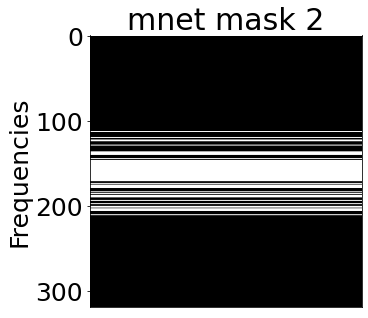

direct input difference:  tensor([[[[-0.0169,  0.0145, -0.0174,  ...,  0.0140,  0.0116,  0.0087],
          [ 0.0115, -0.0109, -0.0198,  ...,  0.0034, -0.0013,  0.0110],
          [ 0.0001, -0.0007,  0.0105,  ..., -0.0036, -0.0043,  0.0219],
          ...,
          [ 0.0145, -0.0116,  0.0126,  ..., -0.0074,  0.0004,  0.0255],
          [ 0.0001,  0.0219, -0.0043,  ..., -0.0052,  0.0105, -0.0007],
          [ 0.0115,  0.0110, -0.0013,  ...,  0.0012, -0.0198, -0.0109]],

         [[ 0.0068, -0.0118,  0.0038,  ..., -0.0193,  0.0106,  0.0073],
          [ 0.0008,  0.0205,  0.0180,  ...,  0.0076,  0.0078,  0.0070],
          [-0.0093,  0.0024,  0.0099,  ...,  0.0233,  0.0068, -0.0097],
          ...,
          [-0.0322, -0.0229, -0.0365,  ..., -0.0185, -0.0179, -0.0008],
          [ 0.0093,  0.0097, -0.0068,  ...,  0.0005, -0.0099, -0.0024],
          [-0.0008, -0.0070, -0.0078,  ..., -0.0099, -0.0180, -0.0205]]]])
sigmoid mnet output difference:  tensor([[-4.8082e-04, -2.2329e-03, -7.5054

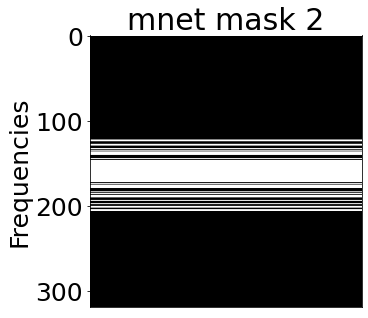

direct input difference:  tensor([[[[-0.0073,  0.0278, -0.0053,  ...,  0.0230,  0.0220,  0.0228],
          [ 0.0234,  0.0012, -0.0048,  ...,  0.0116,  0.0059,  0.0233],
          [-0.0137, -0.0173, -0.0082,  ..., -0.0160, -0.0224,  0.0044],
          ...,
          [ 0.0696,  0.0454,  0.0735,  ...,  0.0469,  0.0555,  0.0811],
          [-0.0137,  0.0044, -0.0224,  ..., -0.0238, -0.0082, -0.0173],
          [ 0.0234,  0.0233,  0.0059,  ...,  0.0134, -0.0048,  0.0012]],

         [[ 0.0205,  0.0043,  0.0233,  ..., -0.0062,  0.0294,  0.0214],
          [-0.0026,  0.0113,  0.0131,  ...,  0.0063,  0.0035,  0.0028],
          [-0.0132, -0.0050,  0.0043,  ...,  0.0154,  0.0031, -0.0144],
          ...,
          [-0.0767, -0.0614, -0.0707,  ..., -0.0611, -0.0580, -0.0420],
          [ 0.0132,  0.0144, -0.0031,  ...,  0.0101, -0.0043,  0.0050],
          [ 0.0026, -0.0028, -0.0035,  ..., -0.0064, -0.0131, -0.0113]]]])
sigmoid mnet output difference:  tensor([[-2.5456e-05, -3.7123e-05, -2.7513

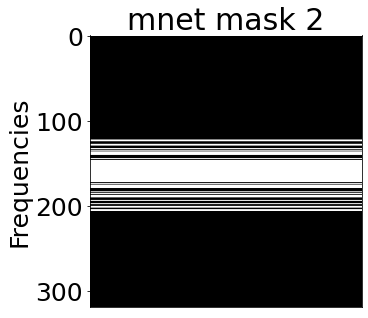

direct input difference:  tensor([[[[ 0.0146,  0.0121, -0.0065,  ...,  0.0366,  0.0450,  0.0311],
          [ 0.0141, -0.0121, -0.0159,  ...,  0.0071, -0.0137,  0.0132],
          [-0.0176, -0.0061,  0.0098,  ...,  0.0034,  0.0042,  0.0180],
          ...,
          [ 0.0046, -0.0103,  0.0263,  ..., -0.0221, -0.0243,  0.0329],
          [-0.0176,  0.0180,  0.0042,  ..., -0.0243,  0.0098, -0.0061],
          [ 0.0141,  0.0132, -0.0137,  ..., -0.0004, -0.0159, -0.0121]],

         [[-0.0020, -0.0173,  0.0079,  ..., -0.0307,  0.0203,  0.0058],
          [-0.0162,  0.0188,  0.0092,  ...,  0.0102,  0.0253,  0.0085],
          [-0.0160, -0.0220, -0.0233,  ...,  0.0206,  0.0042, -0.0069],
          ...,
          [-0.0151, -0.0264, -0.0496,  ..., -0.0135, -0.0188, -0.0103],
          [ 0.0160,  0.0069, -0.0042,  ...,  0.0181,  0.0233,  0.0220],
          [ 0.0162, -0.0085, -0.0253,  ..., -0.0383, -0.0092, -0.0188]]]])
sigmoid mnet output difference:  tensor([[-2.5678e-05, -3.6336e-05, -2.7938

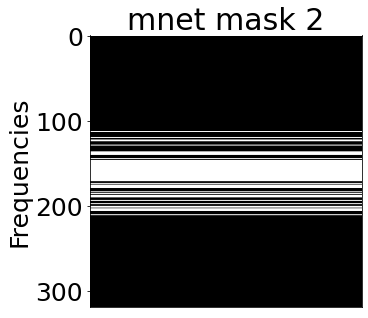

direct input difference:  tensor([[[[-0.0186,  0.0154, -0.0154,  ...,  0.0133,  0.0095,  0.0084],
          [ 0.0196, -0.0068, -0.0163,  ...,  0.0076,  0.0049,  0.0207],
          [-0.0001,  0.0007,  0.0116,  ..., -0.0047, -0.0078,  0.0186],
          ...,
          [ 0.0092, -0.0193,  0.0097,  ..., -0.0126, -0.0031,  0.0201],
          [-0.0001,  0.0186, -0.0078,  ..., -0.0053,  0.0116,  0.0007],
          [ 0.0196,  0.0207,  0.0049,  ...,  0.0066, -0.0163, -0.0068]],

         [[ 0.0091, -0.0105,  0.0085,  ..., -0.0254,  0.0104,  0.0063],
          [-0.0005,  0.0206,  0.0188,  ...,  0.0073,  0.0080,  0.0062],
          [-0.0067,  0.0018,  0.0065,  ...,  0.0198,  0.0056, -0.0059],
          ...,
          [-0.0306, -0.0162, -0.0307,  ..., -0.0179, -0.0161,  0.0011],
          [ 0.0067,  0.0059, -0.0056,  ...,  0.0032, -0.0065, -0.0018],
          [ 0.0005, -0.0062, -0.0080,  ..., -0.0132, -0.0188, -0.0206]]]])
sigmoid mnet output difference:  tensor([[-5.0828e-04, -2.1338e-03, -7.2229

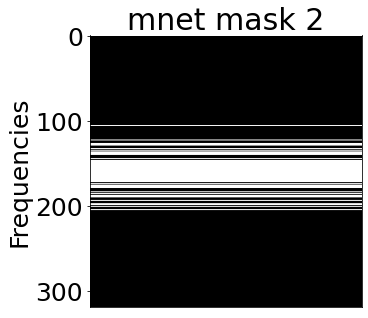

direct input difference:  tensor([[[[-1.7827e-02,  1.6001e-02,  7.4256e-03,  ...,  2.2527e-02,
           -7.7151e-03,  1.8703e-02],
          [ 2.2841e-02, -8.2927e-03, -9.4114e-03,  ...,  1.0029e-02,
           -1.0406e-02,  2.4433e-02],
          [ 9.0779e-03, -4.5683e-03,  8.5990e-03,  ...,  5.0428e-03,
           -6.3633e-03,  3.3799e-02],
          ...,
          [ 7.2908e-03, -5.2663e-03,  2.8322e-02,  ..., -2.2103e-02,
           -1.1657e-02,  1.8794e-02],
          [ 9.0779e-03,  3.3799e-02, -6.3633e-03,  ..., -2.1549e-02,
            8.5990e-03, -4.5683e-03],
          [ 2.2841e-02,  2.4433e-02, -1.0406e-02,  ...,  2.1153e-02,
           -9.4114e-03, -8.2927e-03]],

         [[ 1.8732e-02, -1.3298e-02,  4.6970e-05,  ..., -3.6160e-02,
            1.7067e-02,  3.1053e-03],
          [-8.1891e-03,  6.1384e-03,  3.2165e-02,  ...,  3.2746e-03,
           -6.1807e-03, -3.6539e-03],
          [ 5.1990e-04,  1.0370e-02,  1.7040e-02,  ...,  1.8852e-02,
            1.3170e-03, -1.4712e

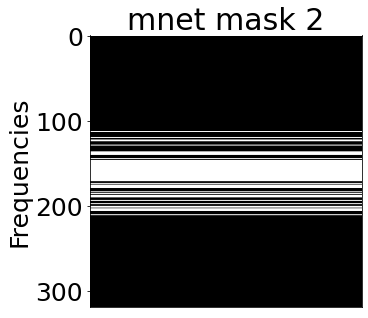

direct input difference:  tensor([[[[-1.9418e-02,  1.3194e-02, -1.2186e-02,  ...,  1.1570e-02,
            8.4987e-03,  4.1427e-03],
          [ 1.7654e-02, -4.9168e-03, -1.4370e-02,  ...,  7.9128e-03,
            4.8212e-06,  1.8246e-02],
          [-3.7605e-03,  2.4631e-03,  1.6447e-02,  ..., -1.0624e-02,
           -1.8389e-02,  9.1507e-03],
          ...,
          [ 1.5010e-02, -9.5751e-03,  1.7289e-02,  ..., -2.3567e-02,
           -9.2413e-03,  2.1243e-02],
          [-3.7605e-03,  9.1507e-03, -1.8389e-02,  ...,  6.3035e-04,
            1.6447e-02,  2.4631e-03],
          [ 1.7654e-02,  1.8246e-02,  4.8212e-06,  ...,  7.7199e-03,
           -1.4370e-02, -4.9168e-03]],

         [[ 9.9538e-03, -4.4960e-03,  1.4140e-02,  ..., -2.6839e-02,
            6.5904e-03,  5.8296e-03],
          [ 3.9154e-03,  2.2891e-02,  2.0120e-02,  ...,  7.6345e-03,
            1.2062e-02,  1.0239e-02],
          [-1.2719e-03,  7.6653e-03,  1.0144e-02,  ...,  1.8945e-02,
            7.6949e-03, -3.1397e

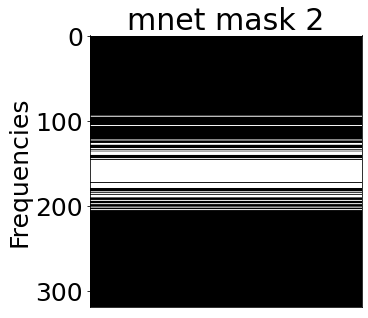

direct input difference:  tensor([[[[-0.0124,  0.0210, -0.0227,  ...,  0.0140,  0.0175,  0.0165],
          [ 0.0407,  0.0054,  0.0015,  ...,  0.0188,  0.0083,  0.0377],
          [-0.0162, -0.0139, -0.0149,  ..., -0.0076, -0.0356,  0.0073],
          ...,
          [ 0.0005, -0.0245,  0.0098,  ..., -0.0312,  0.0019,  0.0033],
          [-0.0162,  0.0073, -0.0356,  ..., -0.0354, -0.0149, -0.0139],
          [ 0.0407,  0.0377,  0.0083,  ...,  0.0145,  0.0015,  0.0054]],

         [[ 0.0156,  0.0048,  0.0199,  ..., -0.0166,  0.0277,  0.0333],
          [ 0.0154,  0.0229,  0.0183,  ...,  0.0174,  0.0194,  0.0157],
          [ 0.0121,  0.0162,  0.0290,  ...,  0.0420,  0.0159, -0.0042],
          ...,
          [-0.0639, -0.0499, -0.0653,  ..., -0.0595, -0.0470, -0.0192],
          [-0.0121,  0.0042, -0.0159,  ..., -0.0135, -0.0290, -0.0162],
          [-0.0154, -0.0157, -0.0194,  ..., -0.0241, -0.0183, -0.0229]]]])
sigmoid mnet output difference:  tensor([[ 2.5495e-11,  9.3582e-11,  2.4185

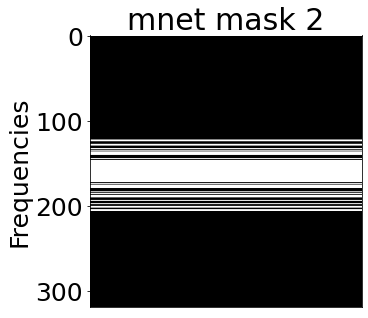

direct input difference:  tensor([[[[-0.0009,  0.0251, -0.0024,  ...,  0.0121,  0.0193,  0.0182],
          [ 0.0245,  0.0010,  0.0008,  ...,  0.0126,  0.0043,  0.0230],
          [ 0.0154,  0.0163,  0.0217,  ...,  0.0225,  0.0067,  0.0380],
          ...,
          [ 0.0281,  0.0022,  0.0253,  ...,  0.0060,  0.0175,  0.0376],
          [ 0.0154,  0.0380,  0.0067,  ...,  0.0076,  0.0217,  0.0163],
          [ 0.0245,  0.0230,  0.0043,  ...,  0.0232,  0.0008,  0.0010]],

         [[-0.0142, -0.0276, -0.0043,  ..., -0.0368, -0.0029, -0.0126],
          [-0.0197, -0.0007,  0.0035,  ..., -0.0060, -0.0086, -0.0142],
          [-0.0307, -0.0218, -0.0171,  ..., -0.0015, -0.0124, -0.0241],
          ...,
          [-0.0194, -0.0035, -0.0149,  ..., -0.0068, -0.0065,  0.0076],
          [ 0.0307,  0.0241,  0.0124,  ...,  0.0144,  0.0171,  0.0218],
          [ 0.0197,  0.0142,  0.0086,  ...,  0.0087, -0.0035,  0.0007]]]])
sigmoid mnet output difference:  tensor([[-4.4693e-05, -7.5496e-05, -5.0665

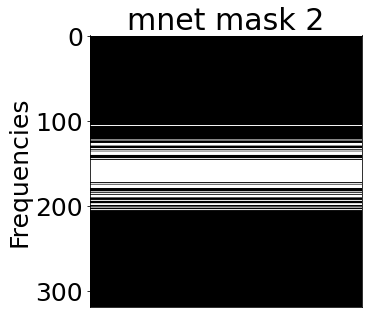

direct input difference:  tensor([[[[-0.0080,  0.0240, -0.0046,  ...,  0.0214,  0.0218,  0.0163],
          [ 0.0204, -0.0078, -0.0154,  ...,  0.0082,  0.0008,  0.0212],
          [-0.0254, -0.0226, -0.0143,  ..., -0.0248, -0.0316, -0.0058],
          ...,
          [ 0.0469,  0.0176,  0.0455,  ...,  0.0192,  0.0321,  0.0518],
          [-0.0254, -0.0058, -0.0316,  ..., -0.0319, -0.0143, -0.0226],
          [ 0.0204,  0.0212,  0.0008,  ...,  0.0053, -0.0154, -0.0078]],

         [[ 0.0130, -0.0064,  0.0107,  ..., -0.0152,  0.0198,  0.0145],
          [ 0.0345,  0.0552,  0.0495,  ...,  0.0424,  0.0401,  0.0392],
          [-0.0091,  0.0016,  0.0060,  ...,  0.0234,  0.0118, -0.0069],
          ...,
          [-0.0437, -0.0293, -0.0404,  ..., -0.0298, -0.0255, -0.0145],
          [ 0.0091,  0.0069, -0.0118,  ...,  0.0011, -0.0060, -0.0016],
          [-0.0345, -0.0392, -0.0401,  ..., -0.0435, -0.0495, -0.0552]]]])
sigmoid mnet output difference:  tensor([[-8.8281e-08, -1.1525e-07, -7.1490

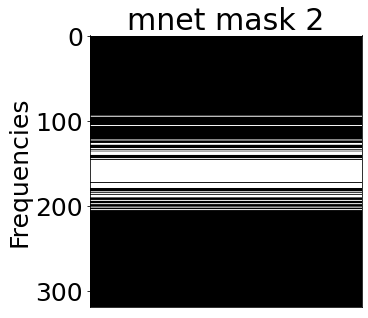

direct input difference:  tensor([[[[-0.0151,  0.0186, -0.0012,  ...,  0.0110,  0.0223,  0.0092],
          [ 0.0277, -0.0060, -0.0062,  ...,  0.0059,  0.0061,  0.0279],
          [ 0.0173,  0.0225,  0.0247,  ...,  0.0240,  0.0167,  0.0328],
          ...,
          [ 0.0210, -0.0156,  0.0188,  ..., -0.0083,  0.0128,  0.0327],
          [ 0.0173,  0.0328,  0.0167,  ...,  0.0138,  0.0247,  0.0225],
          [ 0.0277,  0.0279,  0.0061,  ...,  0.0076, -0.0062, -0.0060]],

         [[-0.0131, -0.0164, -0.0061,  ..., -0.0383,  0.0043, -0.0012],
          [-0.0208,  0.0046,  0.0053,  ..., -0.0040, -0.0018, -0.0075],
          [-0.0160, -0.0106, -0.0031,  ...,  0.0150, -0.0109, -0.0220],
          ...,
          [ 0.0210,  0.0276,  0.0163,  ...,  0.0311,  0.0319,  0.0440],
          [ 0.0160,  0.0220,  0.0109,  ...,  0.0102,  0.0031,  0.0106],
          [ 0.0208,  0.0075,  0.0018,  ...,  0.0129, -0.0053, -0.0046]]]])
sigmoid mnet output difference:  tensor([[ 2.5492e-11,  9.3564e-11,  2.4182

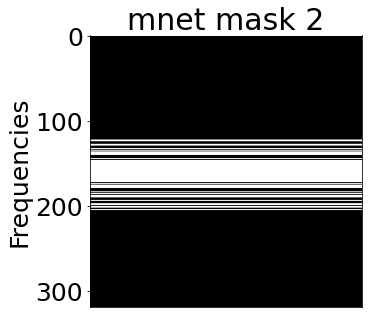

direct input difference:  tensor([[[[-2.2643e-02,  9.8639e-03, -2.1399e-02,  ...,  1.0255e-02,
            1.8388e-03,  4.0942e-03],
          [ 2.6032e-02, -1.1114e-03, -9.6671e-03,  ...,  1.6386e-02,
            1.0735e-02,  2.4310e-02],
          [ 1.6901e-02,  1.5590e-02,  2.8106e-02,  ...,  9.8872e-03,
           -1.2152e-03,  3.3381e-02],
          ...,
          [ 1.8852e-02, -1.1677e-02,  1.1036e-02,  ...,  3.0782e-03,
            1.0799e-02,  3.0315e-02],
          [ 1.6901e-02,  3.3381e-02, -1.2152e-03,  ...,  6.7053e-03,
            2.8106e-02,  1.5590e-02],
          [ 2.6032e-02,  2.4310e-02,  1.0735e-02,  ...,  8.3936e-03,
           -9.6671e-03, -1.1114e-03]],

         [[-8.8864e-03, -2.2835e-02, -3.7484e-03,  ..., -4.3605e-02,
           -1.1493e-02, -1.2508e-02],
          [-5.7987e-03,  1.3535e-02,  1.0913e-02,  ...,  7.7468e-03,
            6.9371e-03,  2.5065e-03],
          [-4.0970e-03,  7.5014e-03,  7.2928e-03,  ...,  3.2654e-02,
            1.7416e-02, -4.8093e

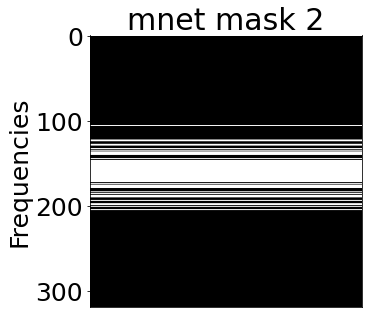

direct input difference:  tensor([[[[-0.0150,  0.0203, -0.0064,  ...,  0.0027,  0.0116,  0.0068],
          [ 0.0171, -0.0042, -0.0067,  ...,  0.0193,  0.0071,  0.0205],
          [ 0.0001, -0.0037,  0.0117,  ...,  0.0061, -0.0040,  0.0241],
          ...,
          [ 0.0159, -0.0172,  0.0237,  ..., -0.0077, -0.0023,  0.0234],
          [ 0.0001,  0.0241, -0.0040,  ..., -0.0124,  0.0117, -0.0037],
          [ 0.0171,  0.0205,  0.0071,  ...,  0.0128, -0.0067, -0.0042]],

         [[ 0.0071, -0.0229, -0.0019,  ..., -0.0244,  0.0122,  0.0076],
          [-0.0069,  0.0120,  0.0185,  ...,  0.0077,  0.0078,  0.0009],
          [-0.0191,  0.0022,  0.0024,  ...,  0.0123, -0.0032, -0.0146],
          ...,
          [-0.0299, -0.0291, -0.0375,  ..., -0.0143, -0.0179,  0.0016],
          [ 0.0191,  0.0146,  0.0032,  ..., -0.0016, -0.0024, -0.0022],
          [ 0.0069, -0.0009, -0.0078,  ..., -0.0093, -0.0185, -0.0120]]]])
sigmoid mnet output difference:  tensor([[-1.6269e-05, -1.9339e-05, -1.6760

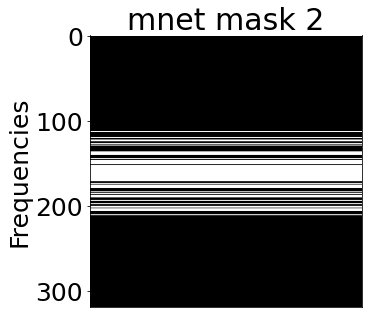

direct input difference:  tensor([[[[-0.0099,  0.0201, -0.0127,  ...,  0.0087,  0.0133,  0.0125],
          [ 0.0213,  0.0014, -0.0079,  ...,  0.0076,  0.0016,  0.0215],
          [ 0.0029,  0.0060,  0.0143,  ..., -0.0049, -0.0102,  0.0170],
          ...,
          [ 0.0057, -0.0131,  0.0181,  ..., -0.0150, -0.0078,  0.0156],
          [ 0.0029,  0.0170, -0.0102,  ..., -0.0059,  0.0143,  0.0060],
          [ 0.0213,  0.0215,  0.0016,  ...,  0.0129, -0.0079,  0.0014]],

         [[ 0.0053, -0.0126,  0.0022,  ..., -0.0279,  0.0077,  0.0037],
          [ 0.0035,  0.0228,  0.0253,  ...,  0.0069,  0.0096,  0.0073],
          [-0.0086,  0.0017,  0.0074,  ...,  0.0167,  0.0015, -0.0080],
          ...,
          [-0.0251, -0.0191, -0.0342,  ..., -0.0227, -0.0164,  0.0028],
          [ 0.0086,  0.0080, -0.0015,  ..., -0.0002, -0.0074, -0.0017],
          [-0.0035, -0.0073, -0.0096,  ..., -0.0150, -0.0253, -0.0228]]]])
sigmoid mnet output difference:  tensor([[-3.4375e-06, -6.2769e-05, -2.5143

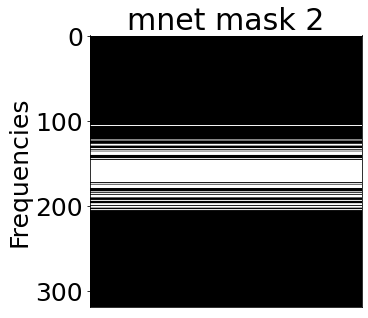

direct input difference:  tensor([[[[-0.0064,  0.0214, -0.0103,  ...,  0.0065,  0.0136,  0.0158],
          [ 0.0148, -0.0107, -0.0142,  ...,  0.0038,  0.0041,  0.0143],
          [ 0.0100, -0.0020,  0.0098,  ...,  0.0039,  0.0016,  0.0227],
          ...,
          [ 0.0083, -0.0145,  0.0126,  ..., -0.0067,  0.0035,  0.0220],
          [ 0.0100,  0.0227,  0.0016,  ..., -0.0131,  0.0098, -0.0020],
          [ 0.0148,  0.0143,  0.0041,  ...,  0.0138, -0.0142, -0.0107]],

         [[-0.0018, -0.0098,  0.0106,  ..., -0.0184,  0.0076,  0.0022],
          [-0.0023,  0.0085,  0.0030,  ...,  0.0019,  0.0134,  0.0162],
          [-0.0081,  0.0097,  0.0219,  ...,  0.0201, -0.0029, -0.0149],
          ...,
          [-0.0365, -0.0271, -0.0397,  ..., -0.0168, -0.0104,  0.0046],
          [ 0.0081,  0.0149,  0.0029,  ..., -0.0087, -0.0219, -0.0097],
          [ 0.0023, -0.0162, -0.0134,  ..., -0.0061, -0.0030, -0.0085]]]])
sigmoid mnet output difference:  tensor([[-1.0443e-05, -1.1812e-05, -1.0360

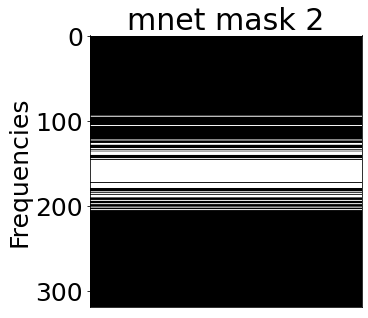

direct input difference:  tensor([[[[-0.0306,  0.0082, -0.0090,  ...,  0.0053,  0.0070,  0.0123],
          [ 0.0175, -0.0075, -0.0330,  ...,  0.0076,  0.0016,  0.0284],
          [-0.0196, -0.0225,  0.0039,  ...,  0.0109,  0.0057,  0.0023],
          ...,
          [ 0.0246, -0.0016,  0.0053,  ...,  0.0006,  0.0078,  0.0246],
          [-0.0196,  0.0023,  0.0057,  ..., -0.0256,  0.0039, -0.0225],
          [ 0.0175,  0.0284,  0.0016,  ...,  0.0066, -0.0330, -0.0075]],

         [[ 0.0171, -0.0043,  0.0242,  ..., -0.0280,  0.0177, -0.0028],
          [ 0.0017, -0.0151,  0.0030,  ..., -0.0138, -0.0230, -0.0151],
          [-0.0128, -0.0070, -0.0086,  ...,  0.0163, -0.0025, -0.0130],
          ...,
          [ 0.0041,  0.0021,  0.0019,  ...,  0.0168,  0.0293,  0.0512],
          [ 0.0128,  0.0130,  0.0025,  ...,  0.0113,  0.0086,  0.0070],
          [-0.0017,  0.0151,  0.0230,  ..., -0.0243, -0.0030,  0.0151]]]])
sigmoid mnet output difference:  tensor([[ 2.4804e-11,  9.0905e-11,  2.3458

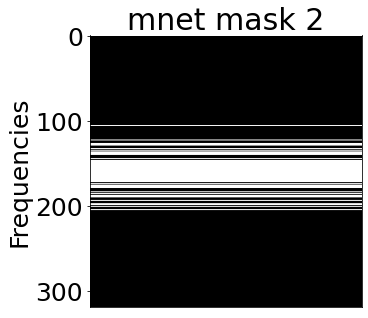

direct input difference:  tensor([[[[-0.0262,  0.0090, -0.0193,  ..., -0.0181, -0.0070, -0.0095],
          [ 0.0063, -0.0133, -0.0126,  ..., -0.0009, -0.0178, -0.0048],
          [-0.0189, -0.0048,  0.0093,  ..., -0.0078, -0.0074,  0.0202],
          ...,
          [ 0.0074, -0.0407,  0.0166,  ..., -0.0333, -0.0100,  0.0027],
          [-0.0189,  0.0202, -0.0074,  ..., -0.0016,  0.0093, -0.0048],
          [ 0.0063, -0.0048, -0.0178,  ...,  0.0158, -0.0126, -0.0133]],

         [[ 0.0152, -0.0269,  0.0097,  ..., -0.0320,  0.0314,  0.0030],
          [-0.0316,  0.0022,  0.0140,  ..., -0.0064, -0.0300, -0.0084],
          [-0.0209, -0.0184, -0.0246,  ...,  0.0058, -0.0056, -0.0264],
          ...,
          [-0.0153, -0.0310, -0.0389,  ..., -0.0054, -0.0012, -0.0084],
          [ 0.0209,  0.0264,  0.0056,  ...,  0.0077,  0.0246,  0.0184],
          [ 0.0316,  0.0084,  0.0300,  ...,  0.0045, -0.0140, -0.0022]]]])
sigmoid mnet output difference:  tensor([[-3.1464e-06, -3.2918e-06, -2.8176

In [13]:
for imgind_2 in range(20):
# imgind_2 = 693
    print(imgind_2)
    img_2 = imgs[imgind_2,:,:].view(1,1,heg,wid)/torch.max(torch.abs(imgs[imgind_2,:,:]))
    kimg_2 = F.fftshift(F.fftn(img_2,dim=(2,3),norm='ortho').to(torch.cfloat)) # kspace shifted

    kimg_lf_2 = torch.zeros(1,2,heg,wid)    
    kimg_lf_2[:,0,lfmask==1,:] = torch.real(kimg_2[:,:,lfmask==1,:])
    kimg_lf_2[:,1,lfmask==1,:] = torch.imag(kimg_2[:,:,lfmask==1,:])

    mnet_mask_2 = mnet_wrapper(mnet,kimg_lf_2,budget=int(heg*sparsity)-preselect_num,\
                                 imgshape=[heg,wid],normalize=True,detach=True)
    mnet_mask_2 = torch.squeeze(mnet_mask_2)

    greedy_mask_2 = labels[imgind_2,:]

    
    # kplot(greedy_mask_2,roll=False,img_name='greedy mask 2')

    slope = 1
    if (mnet_mask_1 - mnet_mask_2).abs().sum() > 0:
        kplot(mnet_mask_2,roll=False,img_name='mnet mask 2')
        print('direct input difference: ',kimg_lf_1[:,:,lfmask==1,:] - kimg_lf_2[:,:,lfmask==1,:])
        print('sigmoid mnet output difference: ',torch.sigmoid(slope * mnet(kimg_lf_1)) - torch.sigmoid(slope * mnet(kimg_lf_2)))
        print('mask difference: ', mnet_mask_1 - mnet_mask_2) 
        print('mnet total line count difference: ', (mnet_mask_1 - mnet_mask_2).abs().sum())

mode is unet


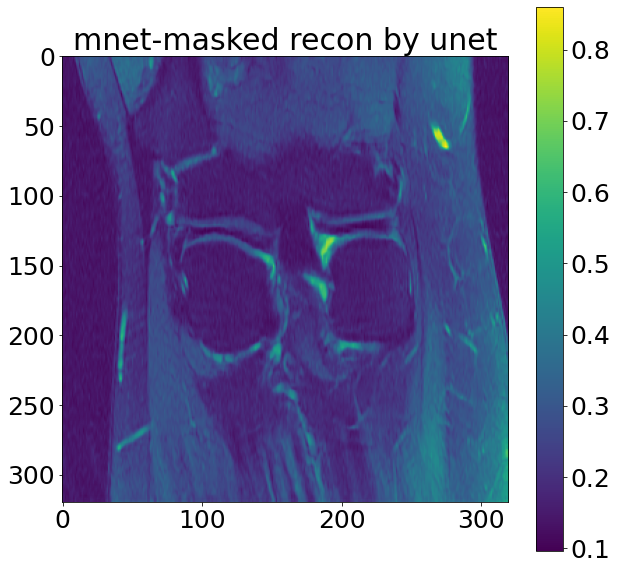

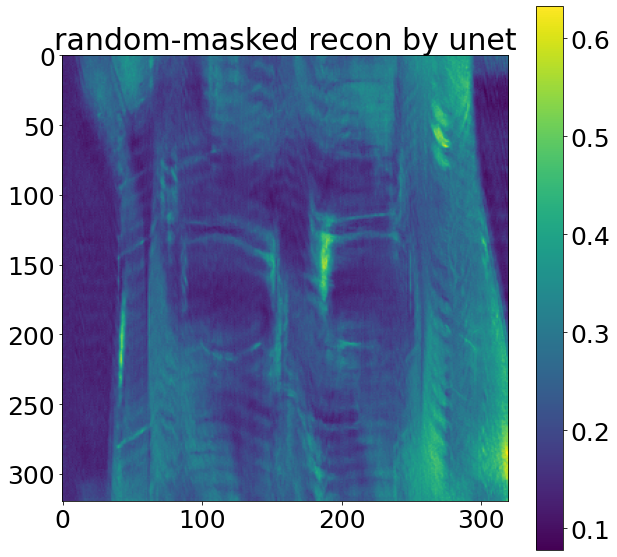

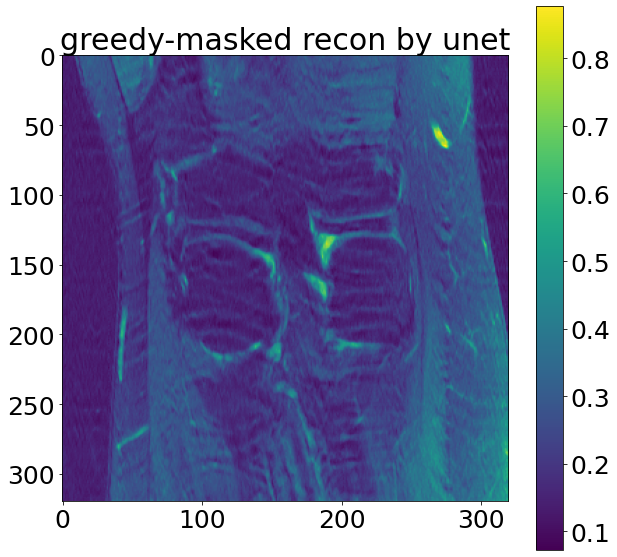

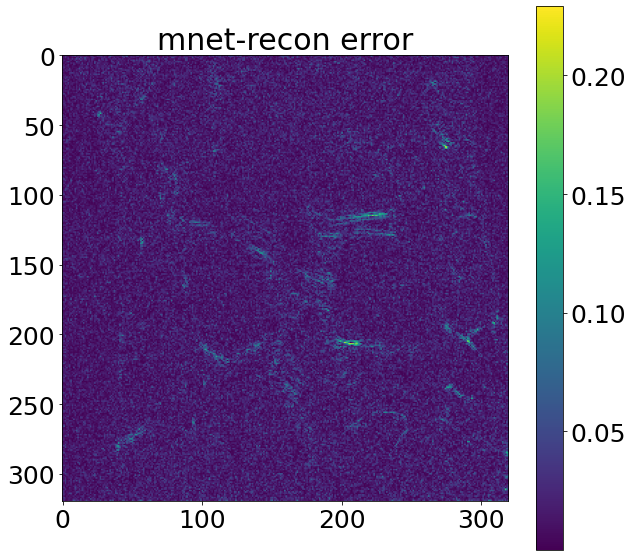

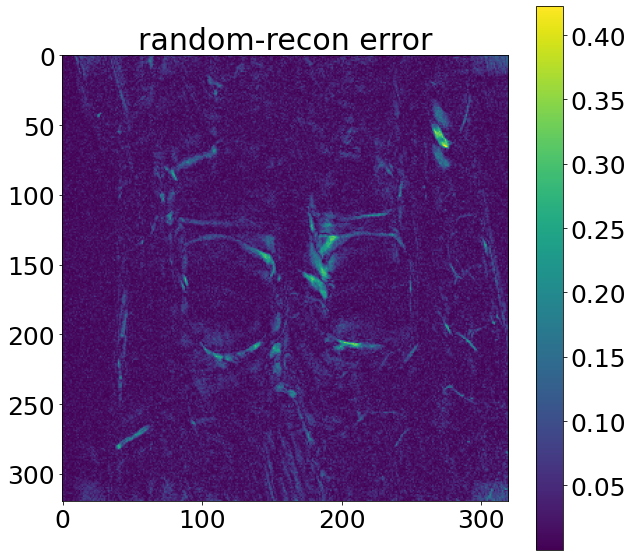

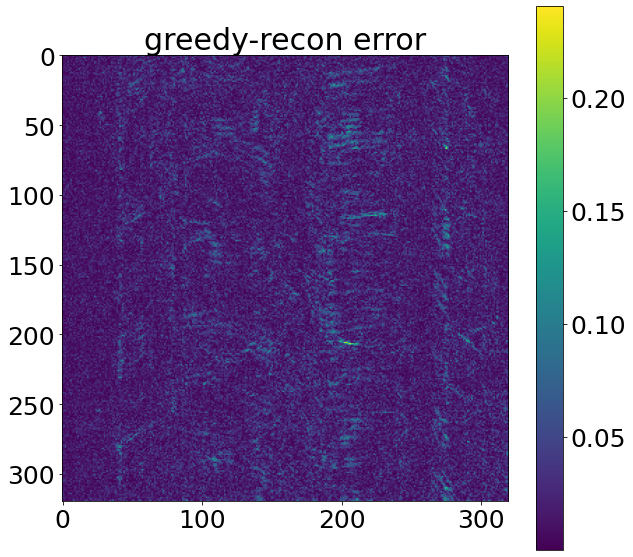

mode is unet
mnet   recon psnr:  [32.155514]
random recon psnr:  [27.576578]
greedy recon psnr:  [30.51899]


mnet   recon ssim:  [0.76881415]
random recon ssim:  [0.65471774]
greedy recon ssim:  [0.717084]


mnet   recon l2 err:  0.09894987596857674
random recon l2 err:  0.16763395392074143
greedy recon l2 err:  0.11946519481831502


mnet   recon l1 err:  0.08101987910849064
random recon l1 err:  0.12448830646696361
greedy recon l1 err:  0.0988131518267586


In [14]:
# image reconstruction
kimg_mn_1 = torch.zeros(1,1,heg,wid).to(torch.cfloat)   
kimg_mn_1[:,:,mnet_mask_1==1,:] = kimg_1[:,:,mnet_mask_1==1,:]
xifft_mn_1 = torch.abs( F.ifftn(F.ifftshift(kimg_mn_1),dim=(2,3),norm='ortho') ) # kspace shifted

kimg_rd_1 = torch.zeros(1,1,heg,wid).to(torch.cfloat)   
kimg_rd_1[:,:,rdmask==1,:] = kimg_1[:,:,rdmask==1,:]
xifft_rd_1 = torch.abs( F.ifftn(F.ifftshift(kimg_rd_1),dim=(2,3),norm='ortho') )

kimg_gr_1 = torch.zeros(1,1,heg,wid).to(torch.cfloat)  
kimg_gr_1[:,:,greedy_mask_1==1,:] = kimg_1[:,:,greedy_mask_1==1,:]
xifft_gr_1 = torch.abs( F.ifftn(F.ifftshift(kimg_gr_1),dim=(2,3),norm='ortho') )

mode = 'unet'
# mode = 'sigpy'
if mode == 'unet':
    print(f'mode is {mode}')
    xrecon_mn_1 = unet_recon(xifft_mn_1).detach()
    xrecon_rd_1 = unet_recon(xifft_rd_1).detach()
    xrecon_gr_1 = unet_recon(xifft_gr_1).detach()
    kplot(xrecon_mn_1[0,0,:,:],img_name='mnet-masked recon by unet')
    kplot(xrecon_rd_1[0,0,:,:],img_name='random-masked recon by unet')
    kplot(xrecon_gr_1[0,0,:,:],img_name='greedy-masked recon by unet')
    kplot(torch.abs(xrecon_mn_1[0,0,:,:] - img_1[0,0,:,:]),img_name='mnet-recon error')
    kplot(torch.abs(xrecon_rd_1[0,0,:,:] - img_1[0,0,:,:]),img_name='random-recon error')
    kplot(torch.abs(xrecon_gr_1[0,0,:,:] - img_1[0,0,:,:]),img_name='greedy-recon error')
    print(f'mode is {mode}')
    print('mnet   recon psnr: ',compute_psnr(xrecon_mn_1.view(-1,320,320), img_1.view(-1,320,320)))
    print('random recon psnr: ',compute_psnr(xrecon_rd_1.view(-1,320,320), img_1.view(-1,320,320)))
    print('greedy recon psnr: ',compute_psnr(xrecon_gr_1.view(-1,320,320), img_1.view(-1,320,320)))
    print('\n')
    print('mnet   recon ssim: ',compute_ssim(xrecon_mn_1.view(-1,320,320), img_1.view(-1,320,320)))
    print('random recon ssim: ',compute_ssim(xrecon_rd_1.view(-1,320,320), img_1.view(-1,320,320)))
    print('greedy recon ssim: ',compute_ssim(xrecon_gr_1.view(-1,320,320), img_1.view(-1,320,320)))
    print('\n')
    print('mnet   recon l2 err: ',(torch.norm(xrecon_mn_1-img_1)/torch.norm(img_1)).item())
    print('random recon l2 err: ',(torch.norm(xrecon_rd_1-img_1)/torch.norm(img_1)).item())
    print('greedy recon l2 err: ',(torch.norm(xrecon_gr_1-img_1)/torch.norm(img_1)).item())
    print('\n')
    print('mnet   recon l1 err: ',(torch.norm(xrecon_mn_1-img_1,p=1)/torch.norm(img_1,p=1)).item())
    print('random recon l1 err: ',(torch.norm(xrecon_rd_1-img_1,p=1)/torch.norm(img_1,p=1)).item())
    print('greedy recon l1 err: ',(torch.norm(xrecon_gr_1-img_1,p=1)/torch.norm(img_1,p=1)).item())
    
elif mode == 'sigpy':
    print(f'mode is {mode}')
    mps = np.ones((1,320,320))
    Lambda = 1e-4
    kimg_mn_1 = kimg_mn_1.view(-1,320,320).numpy()
    xrecon_mn_1 = np.fft.ifftshift( np.abs(TotalVariationRecon(kimg_mn_1, mps, Lambda,show_pbar=False).run()) )
    
    kimg_rd_1 = kimg_rd_1.view(-1,320,320).numpy()
    xrecon_rd_1 = np.fft.ifftshift( np.abs(TotalVariationRecon(kimg_rd_1, mps, Lambda,show_pbar=False).run()) )
    
    kimg_gr_1 = kimg_gr_1.view(-1,320,320).numpy()
    xrecon_gr_1 = np.fft.ifftshift( np.abs(TotalVariationRecon(kimg_gr_1, mps, Lambda,show_pbar=False).run()) )
    
    kplot(xrecon_mn_1,img_name='mnet-masked recon by sigpy')
    kplot(xrecon_rd_1,img_name='random-masked recon by sigpy')
    kplot(xrecon_gr_1,img_name='greedy-masked recon by sigpy')
    kplot(np.abs(xrecon_mn_1 - img_1[0,0,:,:].numpy()),img_name='mnet-recon error')
    kplot(np.abs(xrecon_rd_1 - img_1[0,0,:,:].numpy()),img_name='random-recon error')
    kplot(np.abs(xrecon_gr_1 - img_1[0,0,:,:].numpy()),img_name='greedy-recon error')
    print(f'mode is {mode}')
    print('mnet   recon psnr: ',compute_psnr(torch.tensor(xrecon_mn_1).view(-1,320,320), img_1.view(-1,320,320)))
    print('random recon psnr: ',compute_psnr(torch.tensor(xrecon_rd_1).view(-1,320,320), img_1.view(-1,320,320)))
    print('greedy recon psnr: ',compute_psnr(torch.tensor(xrecon_gr_1).view(-1,320,320), img_1.view(-1,320,320)))
    print('\n')
    print('mnet   recon ssim: ',compute_ssim(torch.tensor(xrecon_mn_1).view(-1,320,320), img_1.view(-1,320,320)))
    print('random recon ssim: ',compute_ssim(torch.tensor(xrecon_rd_1).view(-1,320,320), img_1.view(-1,320,320)))
    print('greedy recon ssim: ',compute_ssim(torch.tensor(xrecon_gr_1).view(-1,320,320), img_1.view(-1,320,320)))
    print('\n')
    print('mnet   recon l2 err: ',(torch.norm(torch.tensor(xrecon_mn_1).view(img_1.shape)-img_1)/torch.norm(img_1)).item())
    print('random recon l2 err: ',(torch.norm(torch.tensor(xrecon_rd_1).view(img_1.shape)-img_1)/torch.norm(img_1)).item())
    print('greedy recon l2 err: ',(torch.norm(torch.tensor(xrecon_gr_1).view(img_1.shape)-img_1)/torch.norm(img_1)).item())
    print('\n')
    print('mnet   recon l1 err: ',(torch.norm(torch.tensor(xrecon_mn_1).view(img_1.shape)-img_1,p=1)/torch.norm(img_1,p=1)).item())
    print('random recon l1 err: ',(torch.norm(torch.tensor(xrecon_rd_1).view(img_1.shape)-img_1,p=1)/torch.norm(img_1,p=1)).item())
    print('greedy recon l1 err: ',(torch.norm(torch.tensor(xrecon_gr_1).view(img_1.shape)-img_1,p=1)/torch.norm(img_1,p=1)).item())
    

# mnet and loupe training error check

In [ ]:
rec = np.load('/home/huangz78/checkpoints/mnet_train_history.npz')
print(rec.files)

In [ ]:
wid1 = 10
wid2 = 5
plt.figure()
plt.plot(rolling_mean(rec['precision_train'],wid1),label='precision')
plt.plot(rolling_mean(rec['recall_train'],wid1),label='recall')
plt.title('training accuracy')
plt.legend()
plt.show()

plt.figure()
plt.title('testing accuracy')
plt.plot(rolling_mean(rec['precision_test'],wid2),label='precision')
plt.plot(rolling_mean(rec['recall_test'],wid2),label='recall')
plt.legend()
plt.show()

plt.figure()
plt.title('train loss in cross entropy')
plt.plot(rolling_mean(rec['loss_train'],20),label='train')
plt.legend()
plt.show()

plt.figure()
plt.title('test loss in cross entropy')
plt.plot(rolling_mean(rec['loss'],8),color='orange',label='test')
plt.legend()
plt.show()


In [ ]:
rec = np.load('/home/huangz78/checkpoints/loupe_history.npz')

In [ ]:
loss_train = rec['loss_train']
loss_val = rec['loss_val']
plt.figure()
plt.plot(loss_train)
plt.xscale('log')
plt.yscale('log')
plt.title('training loss')
plt.show()
plt.figure()
plt.plot(loss_val)
plt.yscale('log')
plt.title('validation loss')
plt.show()

In [2]:
rec = np.load('/home/huangz78/checkpoints/alternating_update_error_track_8fold.npz')
print(rec.files)
# loss_vals = list(rec['loss_val'])
# loss_vals.append(0.10742834150791167)
# print(loss_vals)

['loss_rand', 'loss_after', 'loss_before', 'loss_val']


In [3]:
rec['loss_rand'].shape

(451,)

In [3]:
def rolling_mean(x,window):
    window = int(window)
#   y = np.zeros(x.size-window)
#   for ind in range(y.size):
#       y[ind] = np.mean(x[ind:ind+window])

    # Stephen: for large data, the above gets a bit slow, so we can do this:
#   y = np.convolve(x, np.ones(window)/window, mode='valid')
#   return y
    # or https://stackoverflow.com/a/27681394
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[window:] - cumsum[:-window]) / float(window)

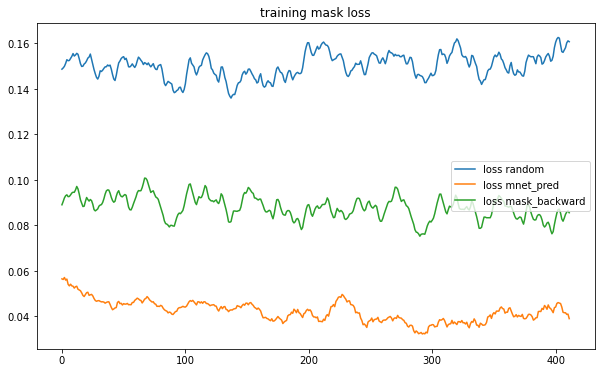

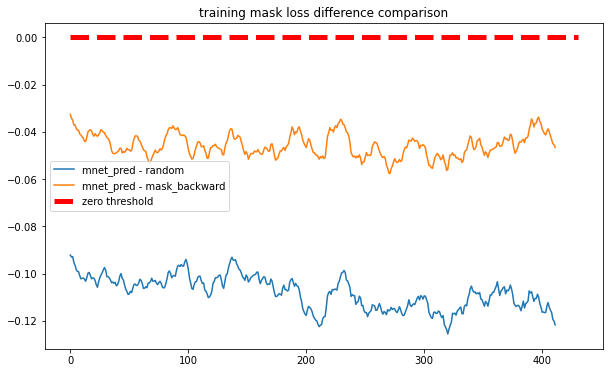

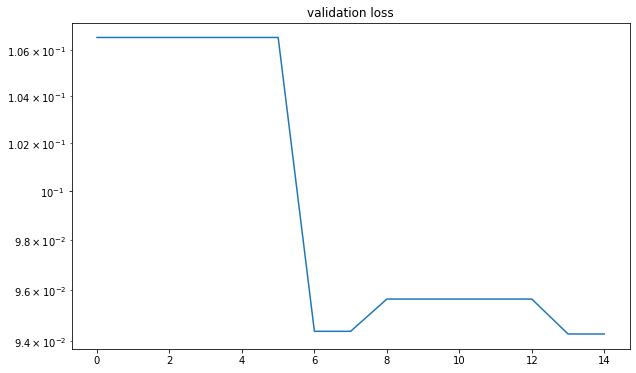

In [8]:
figsize=(10,6)
window = 20

plt.figure(figsize=figsize)
plt.plot(rolling_mean(rec['loss_rand'],window)   ,label='loss random')
plt.plot(rolling_mean(rec['loss_before'],window) ,label='loss mnet_pred')
plt.plot(rolling_mean(rec['loss_after'],window)  ,label='loss mask_backward')
plt.title('training mask loss')
# plt.xscale('log')
# plt.yscale('log')
plt.legend(loc='best')
plt.show()


plt.figure(figsize=figsize)
plt.plot(rolling_mean(rec['loss_before'] - rec['loss_rand'],window)   ,label='mnet_pred - random')
plt.plot(rolling_mean(rec['loss_before'] - rec['loss_after'],window)  ,label='mnet_pred - mask_backward')
zero_line = np.zeros((len(rec['loss_rand'])))
plt.plot(zero_line,'--',label='zero threshold',color='r',linewidth=5)
plt.title('training mask loss difference comparison')
# plt.xscale('log')
# plt.yscale('log')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=figsize)
plt.plot(rec['loss_val'])
plt.title('validation loss')
# plt.xscale('log')
plt.yscale('log')
plt.show()

# mnet quality check: y

In [ ]:
net = MNet(beta=1,in_channels=2,out_size=320-24,\
                   imgsize=(320,320),poolk=3)
checkpoint = torch.load('/home/huangz78/checkpoints/mnet.pth')
net.load_state_dict(checkpoint['model_state_dict'])
print('MNet loaded successfully from: ' + '/home/huangz78/checkpoints/mnet.pth')
net.eval()

imgs = torch.tensor( np.load('/home/huangz78/data/data_gt.npz')['imgdata'] ).permute(2,0,1)
base = 24
mask_lf,_,_ = mask_naiveRand(imgs.shape[1],fix=base,other=0,roll=True)

yfulls = torch.zeros((imgs.shape[0],2,imgs.shape[1],imgs.shape[2]),dtype=torch.float)
ys     = torch.zeros((imgs.shape[0],2,imgs.shape[1],imgs.shape[2]),dtype=torch.float)
xs     = torch.zeros((imgs.shape[0],1,imgs.shape[1],imgs.shape[2]),dtype=torch.float)
for ind in range(imgs.shape[0]):
    imgs[ind,:,:] = imgs[ind,:,:]/torch.max(torch.abs(imgs[ind,:,:]))
    y = torch.fft.fftshift(F.fftn(imgs[ind,:,:],dim=(0,1),norm='ortho'))
    ysub = torch.zeros(y.shape,dtype=y.dtype)
    ysub[mask_lf==1,:] = y[mask_lf==1,:]
    xs[ind,0,:,:] = torch.abs(F.ifftn(torch.fft.ifftshift(ysub),dim=(0,1),norm='ortho')) 

    yfulls[ind,0,:,:] = torch.real(y)
    yfulls[ind,1,:,:] = torch.imag(y)
    ys[ind,:,mask_lf==1,:] = yfulls[ind,:,mask_lf==1,:]

labels = torch.tensor( np.load('/home/huangz78/data/data_gt_greedymask.npz')['mask'].T ) # labels are already rolled

imgNum = imgs.shape[0]
traininds, testinds = train_test_split(np.arange(imgNum),random_state=0,shuffle=True,train_size=round(imgNum*0.8))
test_total  = testinds.size

traindata   = ys[traininds,:,:,:]
valdata     = ys[testinds[0:test_total//2],:,:,:]

trainlabels = mask_filter(labels[traininds,:],base=base)
vallabels   = mask_filter(labels[testinds[0:test_total//2],:],base=base)

In [ ]:
imgind = 19
testimg  = valdata[imgind,:,:,:]
output_1 = net(testimg.view(-1,2,320,320))
binary_1 = sigmoid_binarize(output_1)[0,:]
greedy_1 = vallabels[imgind,:]

imgind = 13
testimg = valdata[imgind,:,:,:]
output_2 = net(testimg.view(-1,2,320,320))
binary_2 = sigmoid_binarize(output_2)[0,:]
greedy_2 = vallabels[imgind,:]

print(torch.sum(torch.abs(binary_1-binary_2)))
print(output_1 - output_2)
# sigmoid_binarize(output)[0,:]

In [ ]:
from utils import mask_complete

In [ ]:
mask_1 = mask_complete(binary_1.view(1,-1),320,rolled=True)
kplot(mask_1.view(-1))
kplot(greedy_1)

# mnet quality check: x

In [ ]:
def mnet_weights_init(m):
    classname = m.__class__.__name__
    print(m)
    if classname.find('Conv2d') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# generate a mnet mask as an example

mnet = MNet(out_size=320-24)
checkpoint = torch.load('/home/huangz78/checkpoints/mnet_split_trained.pth')
mnet.load_state_dict(checkpoint['model_state_dict'])
print('MNet loaded successfully from: ' + '/home/huangz78/checkpoints/mnet_split_trained.pth')

test_dir = '/home/huangz78/data/testdata_x.npz'
# testimg  = torch.tensor(np.load(test_dir)['x']) 
# print(testimg.shape)
# test_sub  = test_sub[0:10,:,:]
test_full = torch.tensor(np.load(test_dir)['xfull']) 
mask_greedy = np.load('/home/huangz78/data/data_gt_greedymask.npz')
mask_greedy = mask_greedy['mask'].T # this greedy mask is rolled

In [ ]:
reload(utils)
from utils import mnet_wrapper

In [ ]:
# imgind = np.random.randint(test_full.shape[0])
mnet.train()
imgind1 = np.random.randint(199)
print('current selected image is indexed: ',imgind1)
img1 = test_full[imgind1,:,:]
imgind2 = np.random.randint(199)
print('current selected image is indexed: ',imgind2)
img2 = test_full[imgind2,:,:]
# plt.imshow(img)
# plt.show()

budget = 56
lowfreqmask,_,_ = mask_naiveRand(img1.shape[0],fix=24,other=0,roll=True)
# randmask,_,_ = mask_naiveRand(img.shape[0],fix=24,other=budget,roll=True)
# kplot(randmask)

yfull1 = torch.fft.fftshift(F.fftn(img1,dim=(0,1),norm='ortho')) # y is ROLLED in this line!
yfull2 = torch.fft.fftshift(F.fftn(img2,dim=(0,1),norm='ortho')) # y is ROLLED!
yfull  = torch.stack((yfull1,yfull2),dim=0)
# x_lf_minus      = -x_lf.clone()
x_lf   = get_x_f_from_yfull(lowfreqmask,yfull,DTyp=torch.cfloat)

In [ ]:
mnet( x_lf.view(x_lf.shape[0],1,img1.shape[0],img1.shape[1]) ).shape

In [ ]:
yfull1.shape

In [ ]:
mnet.eval()
mnetmask = mnet( 1e3*torch.randn(10,1,img1.shape[0],img1.shape[1]) )
# x_lf =  1e3*torch.randn(10,img1.shape[0],img1.shape[1]) 
# highmask_raw = mnet( x_lf.view(x_lf.shape[0],1,img1.shape[0],img1.shape[1]) )
# mnetmask = mnet_wrapper(mnet,x_lf,budget,img1.shape)
print(mnetmask.shape)

torch.sum( torch.abs( mnetmask[0,:] - mnetmask[1,:] ) )

In [ ]:
a = torch.randn(2,2,4,5)
b = torch.randn(2,2,4,5)
c = a[:,0,:,:] + b[:,1,:,:]
print(c.shape)

In [ ]:
highmask_raw  = mnet( x_lf.view(x_lf.shape[0],1,img1.shape[0],img1.shape[1]) ).view(-1)  # no sigmoid 
# highmask_raw  = mnet( 1e10*torch.randn(1,1,img.shape[0],img.shape[1]) ).view(-1)  # no sigmoid 
# print('highmask_raw = ', highmask_raw)
plt.plot(highmask_raw.detach().numpy())
plt.show()
mnetmask = mnet_wrapper(mnet,x_lf,budget,img.shape)
kplot(mnetmask)
kplot(mask_greedy[imgind,:])

In [ ]:
print(mnet.)

In [ ]:
for param in mnet.named_parameters():
      print(param)

In [ ]:
mnetmask_old = mnetmask.clone()
mnetmask - mnetmask_old

In [ ]:
randqual[1:]

In [ ]:
# show quality of mnet
filepath = '/home/huangz78/checkpoints/alternating_update_error_track.npz'
data_loss = np.load(filepath)

print(data_loss.files)

randqual   = data_loss['randqual']
mnetqual   = data_loss['mnetqual']
greedyqual = data_loss['greedyqual']
randspar   = data_loss['randspar']
mnetspar   = data_loss['mnetspar']

try:
    visualization(randqual[1:],mnetqual[1:],greedyqual=greedyqual,\
             randspar=randspar,mnetspar=mnetspar,greedyspar=greedyspar*np.ones(len(greedyqual)))
except Exception:
    visualization(randqual[1:],mnetqual[1:],randspar=randspar,mnetspar=mnetspar,log1=True)